<a href="https://colab.research.google.com/github/bharathulaprasad/Assignment_06/blob/main/BreastCancerData_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import numpy as np # linear algebra
import pandas as pd # data processing
from sklearn.model_selection import train_test_split
#!pip install pydataset
from pydataset import data
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cancerdata = load_breast_cancer()
print(cancerdata.DESCR)





.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [142]:
can = pd.DataFrame(cancerdata.data,columns=cancerdata.feature_names)
can['diagnosis'] = cancerdata.target
can = pd.DataFrame(cancerdata.data,cancerdata.target)
can.isnull().sum().sum()
# This indicates no data cleaning required


0

In [145]:
# estimate how many are 0 and 1 is present in target diagnosis
pd.crosstab(index = cancerdata.target, columns = 'count')

col_0,count
row_0,
0,212
1,357


In [146]:
can.describe().unstack()

0   count    569.000000
    mean      14.127292
    std        3.524049
    min        6.981000
    25%       11.700000
                ...    
29  min        0.055040
    25%        0.071460
    50%        0.080040
    75%        0.092080
    max        0.207500
Length: 240, dtype: float64

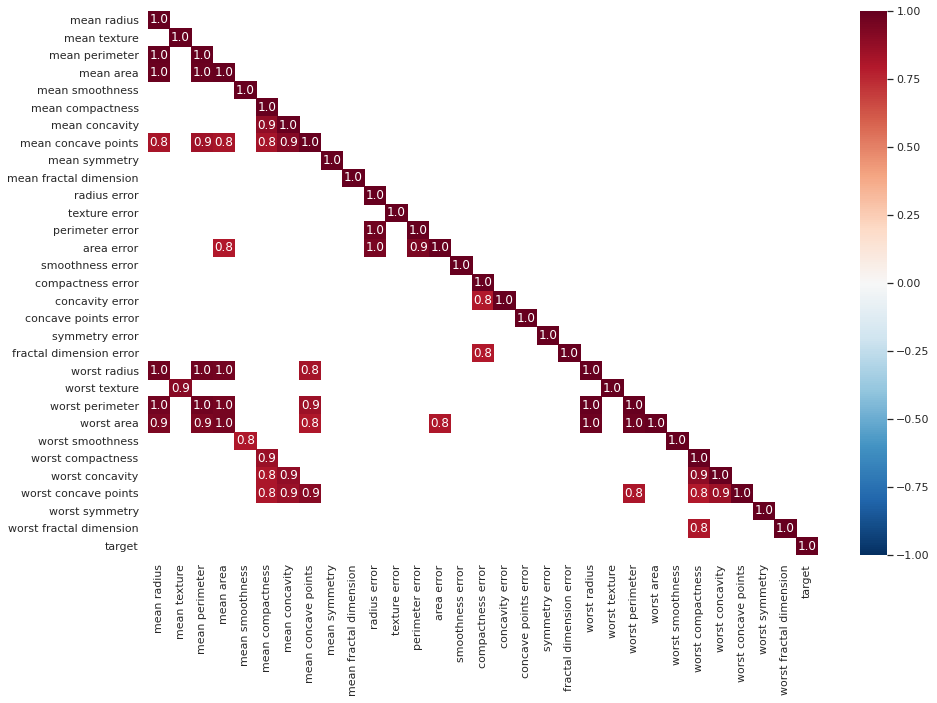

In [195]:
# Create correlation matrix
df_features = pd.DataFrame(cancerdata.data, columns = cancerdata.feature_names)
df_target = pd.DataFrame(cancerdata.target, columns=['target'])

df = pd.concat([df_features, df_target], axis=1)
corr_mat = df.corr()

# Create mask
mask = np.zeros_like(corr_mat, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat[corr_mat > 0.8], annot=True, fmt='.1f',
            cmap='RdBu_r', vmin=-1, vmax=1,
            mask=mask)

In [194]:
##I will use Univariate Feature Selection (sklearn.feature_selection.SelectKBest) 
##to choose 5 features with the k highest scores. 
##I choose 5 because from the heatmap I could see about 5 groups of features that are highly correlated.
from sklearn.feature_selection import SelectKBest, chi2
feature_selection = SelectKBest(chi2, k=5)
feature_selection.fit(df_features, df_target)
selected_features = df_features.columns[feature_selection.get_support()]
print("The five selected features are: ", list(selected_features))

The five selected features are:  ['mean perimeter', 'mean area', 'area error', 'worst perimeter', 'worst area']


In [178]:
X = pd.DataFrame(feature_selection.transform(df_features),
                 columns=selected_features)
X.head()

,mean perimeter,mean area,area error,worst perimeter,worst area
0,122.80,1001.0,153.40,184.60,2019.0
1,132.90,1326.0,74.08,158.80,1956.0
2,130.00,1203.0,94.03,152.50,1709.0
3,77.58,386.1,27.23,98.87,567.7
4,135.10,1297.0,94.44,152.20,1575.0


In [83]:
can = pd.DataFrame(cancerdata.data,columns=cancerdata.feature_names)
can['diagnosis'] = cancerdata.target
can.sample(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
295,13.77,13.27,88.06,582.7,0.09198,0.06221,0.01063,0.01917,0.1592,0.05912,0.2191,0.6946,1.479,17.74,0.004348,0.008153,0.004272,0.006829,0.02154,0.001802,14.67,16.93,94.17,661.1,0.11700,0.10720,0.03732,0.05802,0.2823,0.06794,1
380,11.27,12.96,73.16,386.3,0.12370,0.11110,0.07900,0.05550,0.2018,0.06914,0.2562,0.9858,1.809,16.04,0.006635,0.017770,0.021010,0.011640,0.02108,0.003721,12.84,20.53,84.93,476.1,0.16100,0.24290,0.22470,0.13180,0.3343,0.09215,1
348,11.47,16.03,73.02,402.7,0.09076,0.05886,0.02587,0.02322,0.1634,0.06372,0.1707,0.7615,1.090,12.25,0.009191,0.008548,0.009400,0.006315,0.01755,0.003009,12.51,20.79,79.67,475.8,0.15310,0.11200,0.09823,0.06548,0.2851,0.08763,1
443,10.57,18.32,66.82,340.9,0.08142,0.04462,0.01993,0.01111,0.2372,0.05768,0.1818,2.5420,1.277,13.12,0.010720,0.013310,0.019930,0.011110,0.01717,0.004492,10.94,23.31,69.35,366.3,0.09794,0.06542,0.03986,0.02222,0.2699,0.06736,1
491,17.85,13.23,114.60,992.1,0.07838,0.06217,0.04445,0.04178,0.1220,0.05243,0.4834,1.0460,3.163,50.95,0.004369,0.008274,0.011530,0.007437,0.01302,0.001309,19.82,18.42,127.10,1210.0,0.09862,0.09976,0.10480,0.08341,0.1783,0.05871,1


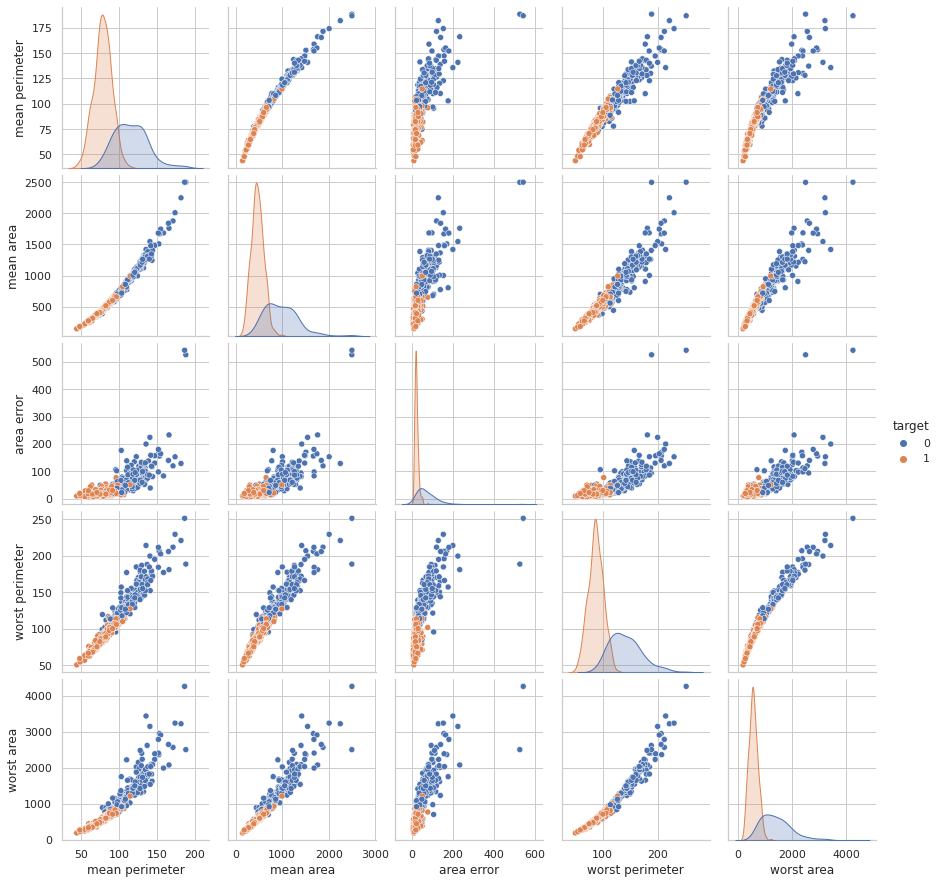

In [179]:
sns.pairplot(pd.concat([X, df['target']], axis=1), hue='target')

In [180]:
from sklearn.model_selection import train_test_split
y = df_target['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.10,test_size=0.90, random_state=42)

In [182]:
#Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
#Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[166  27]
 [ 39 281]]


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83       193
           1       0.91      0.88      0.89       320

    accuracy                           0.87       513
   macro avg       0.86      0.87      0.86       513
weighted avg       0.87      0.87      0.87       513



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Second Principal Component')

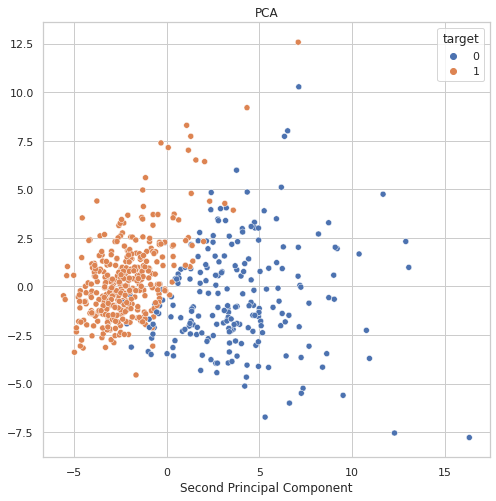

In [190]:
#PCA analysis to analyse distribution of the features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_features)

features_scaled = scaler.transform(df_features)

features_scaled = pd.DataFrame(data=features_scaled,
                               columns=df_features.columns)
features_scaled.head(5)
df_scaled = pd.concat([features_scaled, df['target']], axis=1)
X_scaled = features_scaled
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
plt.figure(figsize=(8, 8))
sns.scatterplot(X_pca[:, 0], X_pca[:, 1], hue=df['target'])
plt.title("PCA")
plt.xlabel("First Principal Component")
plt.xlabel("Second Principal Component")

In [89]:
X_train, X_test, y_train, y_test = train_test_split(cancerdata.data, cancerdata.target, stratify=cancerdata.target, train_size=0.10, test_size=0.90, random_state=42)
log_reg = LogisticRegression(max_iter=100000)
log_reg.fit(X_train, y_train)
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_train,y_train)))
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_test,y_test)))


Accuracy on the training set: 0.982
Accuracy on the training set: 0.940


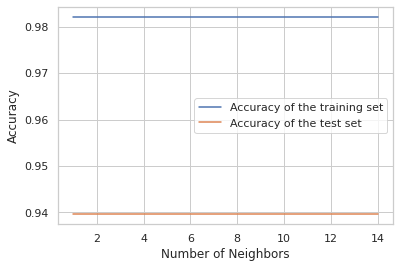

In [90]:
#drawing the graph
training_accuracy = []
test_accuracy = []

#try log_reg for diffrent k nearest neighbor from 1 to 15
neighbors_setting = range(1,15)

for n_neighbors in neighbors_setting:
    log_reg = LogisticRegression(max_iter=100000)
    log_reg.fit(X_train,y_train)
    training_accuracy.append(log_reg.score(X_train, y_train))
    test_accuracy.append(log_reg.score(X_test, y_test))
 
plt.plot(neighbors_setting,training_accuracy, label='Accuracy of the training set')
plt.plot(neighbors_setting,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.legend()

Accuracy on the training set: 0.965
Accuracy on the training set: 0.932


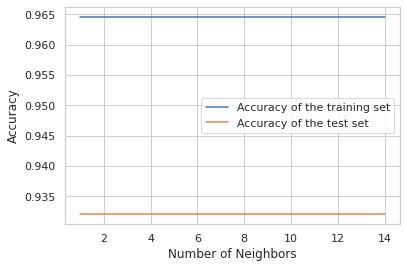

In [91]:
X_train, X_test, y_train, y_test = train_test_split(cancerdata.data, cancerdata.target, stratify=cancerdata.target, train_size=0.20, test_size=0.80, random_state=42)
log_reg = LogisticRegression(max_iter=100000)
log_reg.fit(X_train, y_train)
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_train,y_train)))
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_test,y_test)))
training_accuracy = []
test_accuracy = []

#try log_reg for diffrent k nearest neighbor from 1 to 15
neighbors_setting = range(1,15)

for n_neighbors in neighbors_setting:
    log_reg = LogisticRegression(max_iter=100000)
    log_reg.fit(X_train,y_train)
    training_accuracy.append(log_reg.score(X_train, y_train))
    test_accuracy.append(log_reg.score(X_test, y_test))
 
plt.plot(neighbors_setting,training_accuracy, label='Accuracy of the training set')
plt.plot(neighbors_setting,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.legend()

Accuracy on the training set: 0.988
Accuracy on the training set: 0.945


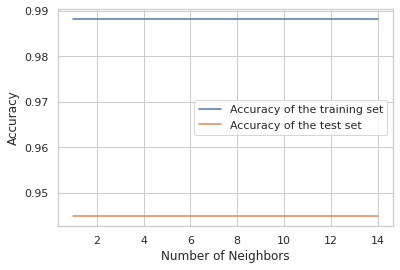

In [92]:
X_train, X_test, y_train, y_test = train_test_split(cancerdata.data, cancerdata.target, stratify=cancerdata.target, train_size=0.30, test_size=0.70, random_state=42)
log_reg = LogisticRegression(max_iter=100000)
log_reg.fit(X_train, y_train)
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_train,y_train)))
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_test,y_test)))
training_accuracy = []
test_accuracy = []

#try log_reg for diffrent k nearest neighbor from 1 to 15
neighbors_setting = range(1,15)

for n_neighbors in neighbors_setting:
    log_reg = LogisticRegression(max_iter=100000)
    log_reg.fit(X_train,y_train)
    training_accuracy.append(log_reg.score(X_train, y_train))
    test_accuracy.append(log_reg.score(X_test, y_test))
 
plt.plot(neighbors_setting,training_accuracy, label='Accuracy of the training set')
plt.plot(neighbors_setting,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.legend()

Accuracy on the training set: 0.978
Accuracy on the training set: 0.944


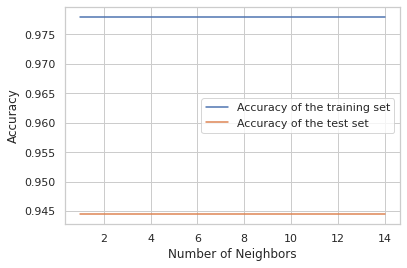

In [93]:
X_train, X_test, y_train, y_test = train_test_split(cancerdata.data, cancerdata.target, stratify=cancerdata.target, train_size=0.40, test_size=0.60, random_state=42)
log_reg = LogisticRegression(max_iter=100000)
log_reg.fit(X_train, y_train)
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_train,y_train)))
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_test,y_test)))
training_accuracy = []
test_accuracy = []

#try log_reg for diffrent k nearest neighbor from 1 to 15
neighbors_setting = range(1,15)

for n_neighbors in neighbors_setting:
    log_reg = LogisticRegression(max_iter=100000)
    log_reg.fit(X_train,y_train)
    training_accuracy.append(log_reg.score(X_train, y_train))
    test_accuracy.append(log_reg.score(X_test, y_test))
 
plt.plot(neighbors_setting,training_accuracy, label='Accuracy of the training set')
plt.plot(neighbors_setting,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.legend()

Accuracy on the training set: 0.968
Accuracy on the training set: 0.954


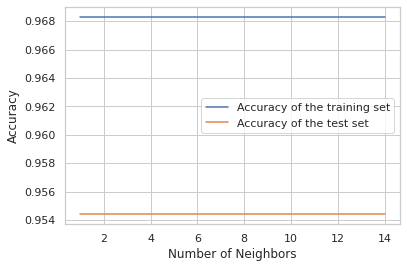

In [94]:
X_train, X_test, y_train, y_test = train_test_split(cancerdata.data, cancerdata.target, stratify=cancerdata.target, train_size=0.50, test_size=0.50, random_state=42)
log_reg = LogisticRegression(max_iter=100000)
log_reg.fit(X_train, y_train)
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_train,y_train)))
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_test,y_test)))
training_accuracy = []
test_accuracy = []

#try log_reg for diffrent k nearest neighbor from 1 to 15
neighbors_setting = range(1,15)

for n_neighbors in neighbors_setting:
    log_reg = LogisticRegression(max_iter=100000)
    log_reg.fit(X_train,y_train)
    training_accuracy.append(log_reg.score(X_train, y_train))
    test_accuracy.append(log_reg.score(X_test, y_test))
 
plt.plot(neighbors_setting,training_accuracy, label='Accuracy of the training set')
plt.plot(neighbors_setting,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.legend()

Accuracy on the training set: 0.962
Accuracy on the training set: 0.943


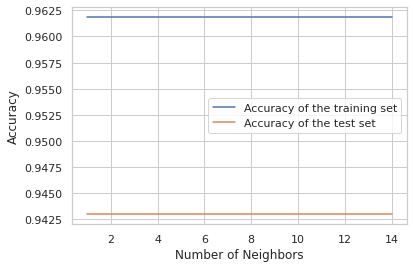

In [95]:
X_train, X_test, y_train, y_test = train_test_split(cancerdata.data, cancerdata.target, stratify=cancerdata.target, train_size=0.60, test_size=0.40, random_state=42)
log_reg = LogisticRegression(max_iter=100000)
log_reg.fit(X_train, y_train)
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_train,y_train)))
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_test,y_test)))
training_accuracy = []
test_accuracy = []

#try log_reg for diffrent k nearest neighbor from 1 to 15
neighbors_setting = range(1,15)

for n_neighbors in neighbors_setting:
    log_reg = LogisticRegression(max_iter=100000)
    log_reg.fit(X_train,y_train)
    training_accuracy.append(log_reg.score(X_train, y_train))
    test_accuracy.append(log_reg.score(X_test, y_test))
 
plt.plot(neighbors_setting,training_accuracy, label='Accuracy of the training set')
plt.plot(neighbors_setting,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.legend()

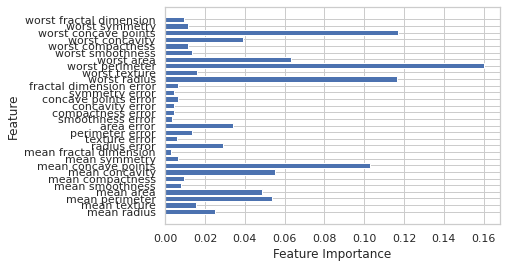

In [99]:
#Feature importance
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(cancerdata.data, cancerdata.target, random_state=0)

forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train,y_train)

n_feature = cancerdata.data.shape[1]
plt.barh(range(n_feature), forest.feature_importances_, align='center')
plt.yticks(np.arange(n_feature), cancerdata.feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

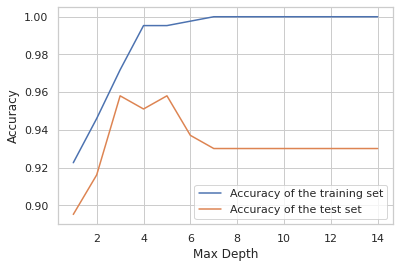

In [101]:
#----------------- Decision Tree
from sklearn.tree import DecisionTreeClassifier        #Decision Tree
X_train, X_test, y_train, y_test = train_test_split(cancerdata.data, cancerdata.target, random_state=42)

training_accuracy = []
test_accuracy = []

max_dep = range(1,15)

for md in max_dep:
    tree = DecisionTreeClassifier(max_depth=md,random_state=0)
    tree.fit(X_train,y_train)
    training_accuracy.append(tree.score(X_train, y_train))
    test_accuracy.append(tree.score(X_test, y_test))
 
plt.plot(max_dep,training_accuracy, label='Accuracy of the training set')
plt.plot(neighbors_setting,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.legend()